In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings

In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, GaussianSpatialModel, PowerLawSpectralModel
from gammapy.irf import EDispKernel, PSFMap, PSFKernel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion
from hawc_dataset import HAWCMapDataset
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
)

In [3]:
#initial values are taken from https://arxiv.org/pdf/1909.08609.pdf 
spatial_model = GaussianSpatialModel(
    lon_0="304.95 deg",
    lat_0="36.78  deg",
    sigma="0.30 deg",
    frame="icrs"
)

spatial_model.lon_0.error = "0.07 deg"
spatial_model.lat_0.error = "0.04 deg"
spatial_model.sigma.error = "0.02 deg"
spatial_model.lon_0.frozen = True
spatial_model.lat_0.frozen = True
#spatial_model.sigma.frozen = True

spectral_model = LogParabolaSpectralModel(
    amplitude="0.45e-13 TeV-1 cm-2 s-1",
    alpha=2.08,
    beta=0.26,
    reference="10 TeV"
)
spectral_model.amplitude.error = "0.03e-13 TeV-1 cm-2 s-1"
spectral_model.alpha.error = 0.06
spectral_model.beta.error = 0.05

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name='j2019 model')

In [4]:
from gammapy.modeling.models import Models
models = Models([])

In [5]:
%%time
hawc_datasets_nHitBin = []

for i in range(1,10):
    dataset =  HAWCMapDataset.read('gammapy_dataset_vikas/{}nHitBin.fits.gz'.format(i))
    dataset._models = models.copy()
    dataset.models.append(model)
    hawc_datasets_nHitBin.append(dataset)

CPU times: user 26.2 s, sys: 1.76 s, total: 28 s
Wall time: 31.8 s


In [6]:
print(model)

SkyModel

  Name                      : j2019 model
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   4.50e-14  1 / (cm2 s TeV)
    reference    (frozen)   :  10.000  TeV         
    alpha                   :   2.080              
    beta                    :   0.260              
    lon_0        (frozen)   : 304.950  deg         
    lat_0        (frozen)   :  36.780  deg         
    sigma                   :   0.300  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         




In [7]:
len(hawc_datasets_nHitBin)

9

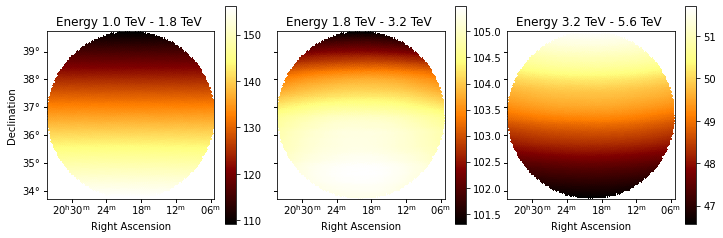

In [8]:
hawc_datasets_nHitBin[0].background.plot_grid(add_cbar=True)
plt.show()

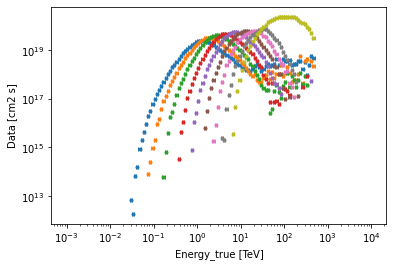

In [9]:
for dat in hawc_datasets_nHitBin:
    dat.exposure.get_spectrum().plot()
plt.show()

In [10]:
fit = Fit(hawc_datasets_nHitBin)

In [11]:
%%time
result = fit.run()

CPU times: user 3min 52s, sys: 2min 42s, total: 6min 35s
Wall time: 6min 35s


In [12]:
print(model)

SkyModel

  Name                      : j2019 model
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   4.40e-14  1 / (cm2 s TeV)
    reference    (frozen)   :  10.000  TeV         
    alpha                   :   2.073              
    beta                    :   0.269              
    lon_0        (frozen)   : 304.950  deg         
    lat_0        (frozen)   :  36.780  deg         
    sigma                   :   0.309  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         




In [13]:
#https://arxiv.org/pdf/1909.08609.pdf
ref_spatial_model = GaussianSpatialModel(
    lon_0="304.95 deg",
    lat_0="36.78  deg",
    sigma="0.30 deg",
    frame="icrs"
)

ref_spatial_model.lon_0.error = "0.07 deg"
ref_spatial_model.lat_0.error = "0.04 deg"
ref_spatial_model.sigma.error = "0.02 deg"

ref_spectral_model = LogParabolaSpectralModel(
    amplitude="0.45e-13 TeV-1 cm-2 s-1",
    alpha=2.08,
    beta=0.26,
    reference="10 TeV"
)
ref_spectral_model.amplitude.error = "0.03e-13 TeV-1 cm-2 s-1"
ref_spectral_model.alpha.error = 0.06
ref_spectral_model.beta.error = 0.05

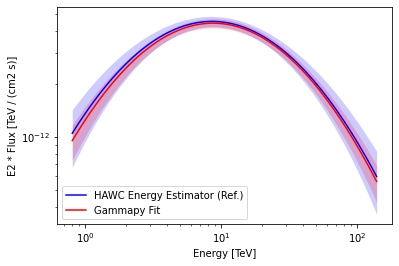

In [14]:
ax = ref_spectral_model.plot(energy_range=(0.8, 140) * u.TeV, energy_power=2, label="HAWC Energy Estimator (Ref.)", color='blue')
ref_spectral_model.plot_error(ax=ax, energy_range=(0.8, 140) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())
spectral_model.plot(ax=ax, energy_range=(0.8, 140) * u.TeV, energy_power=2, label="Gammapy Fit", color='red')
spectral_model.plot_error(ax=ax, energy_range=(0.8, 140) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())

plt.legend()
plt.savefig("plots_vikas/energy-spectrum-j2019.png", dpi=300, bbox_inches='tight')

In [15]:
print(ref_spectral_model)

LogParabolaSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
amplitude 4.5000e-14 cm-2 s-1 TeV-1 nan nan  False 3.000e-15
reference 1.0000e+01            TeV nan nan   True 0.000e+00
    alpha 2.0800e+00                nan nan  False 6.000e-02
     beta 2.6000e-01                nan nan  False 5.000e-02


In [16]:
print(spectral_model)

LogParabolaSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
amplitude 4.4038e-14 cm-2 s-1 TeV-1 nan nan  False 2.652e-15
reference 1.0000e+01            TeV nan nan   True 0.000e+00
    alpha 2.0730e+00                nan nan  False 4.557e-02
     beta 2.6890e-01                nan nan  False 3.359e-02


In [17]:
print(ref_spatial_model)

GaussianSpatialModel

 name   value    unit    min        max    frozen   error  
----- ---------- ---- ---------- --------- ------ ---------
lon_0 3.0495e+02  deg        nan       nan  False 7.000e-02
lat_0 3.6780e+01  deg -9.000e+01 9.000e+01  False 4.000e-02
sigma 3.0000e-01  deg  0.000e+00       nan  False 2.000e-02
    e 0.0000e+00       0.000e+00 1.000e+00   True 0.000e+00
  phi 0.0000e+00  deg        nan       nan   True 0.000e+00


In [18]:
print(spatial_model)

GaussianSpatialModel

 name   value    unit    min        max    frozen   error  
----- ---------- ---- ---------- --------- ------ ---------
lon_0 3.0495e+02  deg        nan       nan   True 0.000e+00
lat_0 3.6780e+01  deg -9.000e+01 9.000e+01   True 0.000e+00
sigma 3.0938e-01  deg  0.000e+00       nan  False 1.625e-02
    e 0.0000e+00       0.000e+00 1.000e+00   True 0.000e+00
  phi 0.0000e+00  deg        nan       nan   True 0.000e+00


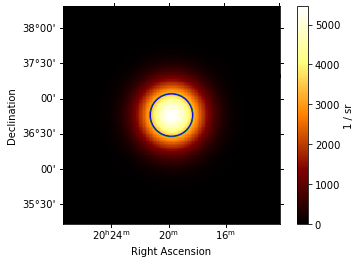

In [19]:
import matplotlib.patches as mpatches
handles = []

ax = spatial_model.plot(add_cbar=True)
# add region illustration
region = spatial_model.to_region()
region_pix = region.to_pixel(ax.wcs)
ax.add_artist(region_pix.as_artist());
ref_region = ref_spatial_model.to_region()
ref_region_pix = ref_region.to_pixel(ax.wcs)
ax.add_artist(ref_region_pix.as_artist(edgecolor="blue"));

In [20]:
%%time
eaxis = MapAxis.from_bounds(1, 316, nbin=10, name="energy", interp="log", unit="TeV")
# Compute flux points for hawc energy estimator maps
fp_hawc_datasets_nHitBin = FluxPointsEstimator(energy_edges=eaxis.edges, source='j2019 model')
flux_points_hawc_datasets_nHitBin = fp_hawc_datasets_nHitBin.run(hawc_datasets_nHitBin)
flux_points_hawc_datasets_nHitBin.table["is_ul"] = flux_points_hawc_datasets_nHitBin.table["ts"] < 4

CPU times: user 23min 10s, sys: 22min, total: 45min 10s
Wall time: 45min 20s


In [21]:
flux_points_hawc_datasets_nHitBin.write("j2019_flux_points.fits", overwrite=True)

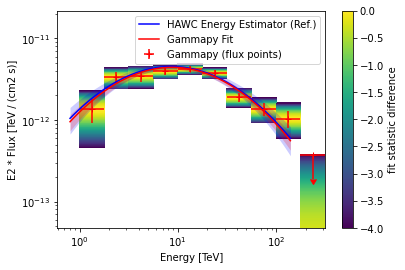

In [22]:
ax = ref_spectral_model.plot(energy_range=(0.8, 140) * u.TeV, energy_power=2, label="HAWC Energy Estimator (Ref.)", color='blue')
ref_spectral_model.plot_error(energy_range=(0.8, 140) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
flux_points_hawc_datasets_nHitBin.plot(ax=ax, energy_power=2, label="Gammapy (flux points)", color='red')
flux_points_hawc_datasets_nHitBin.to_sed_type("e2dnde").plot_ts_profiles(ax=ax, cmap='viridis',  y_unit="TeV cm-2 s-1")
spectral_model.plot(ax=ax, energy_range=(0.8, 140) * u.TeV, energy_power=2, label="Gammapy Fit",color='red')
spectral_model.plot_error(ax=ax, energy_range=(0.8, 140) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())

plt.legend()
plt.savefig("plots_vikas/j2019-hawc-flux-points.png", dpi=300, bbox_inches='tight')